# Machine Learning for Data Analysis
# Assignment: Running a Random Forest

Following is the Python program I wrote to fulfill the second assignment of the [Machine Learning for Data Analysis online course](https://www.coursera.org/learn/machine-learning-data-analysis/home/welcome).

I decided to use [Jupyter Notebook](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb) as it is a pretty way to write code and present results.

## Research question for this assignment

For this assignment, I took the same research question as for the [previous assignement](ClassificationTree.ipynb). I decided to use the NESARC database with the following question : *Are people from white ethnicity more likely to have ever used cannabis?*

The explanatory variables will be:

- Age (Quantitative variable)
- Sex (0 = Female, 1 = Male)
- Family income (grouped in 5 categories)
- Ever smoked 100+ cigarettes (0 = No, 1 = Yes)
- Ethnicity (Each of them are recoded 0 = No, 1 = Yes):
    - White
    - Black
    - Native American
    - Pacific islander
    - Asian
    - Hispanic
- Raised by who (Each of them are recoded 0 = No, 1 = Yes):
    - Biological parents (i.e. lives with at least one biological parent)
    - Adoptive parents
    - Relatives
    - Foster parents
    - In institution
    - Other
- Did biological parents get divorced (0 = No, 1 = Yes)
- Highest grade completed : coded from 1 (no schooling) to 14 (completed graduate)
- Occupation (Each of them are recoded 0 = No, 1 = Yes):
    - Full time (35+ hours a week)
    - Part time (<35 hours a week)
    - Unemployed and looking for work
    - Unemployed and not looking for work


## Data management

The data will be managed to get cannabis usage recoded from 0 (never used cannabis) and 1 (used cannabis). The non-answering recordings (reported as 9) will be discarded.

The response variable having 2 categories, categories grouping is not needed.

In [1]:
# Magic command to insert the graph directly in the notebook
%matplotlib inline
# Load a useful Python libraries for handling data
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display, Image

In [3]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier

In [4]:
nesarc = pd.read_csv('nesarc_pds.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
boolean_flip_ignore = {1 : 1, 2 : 0, 9 : np.nan}
boolean_flip_ignore_str = {'1' : 1, '2' : 0, '9' : np.nan, ' ' : 0}
boolean_flip = {1 : 1, 2 : 0}

# Group the family income in two groups splitting it on the second quartile class
def income_group(value):
    if value < 5:
        return 0
    elif value < 9:
        return 1
    elif value < 13:
        return 2
    elif value < 17:
        return 3
    else:
        return 4

subnesarc = (nesarc[['AGE', 'SEX', 'S1Q7D', 'S3BQ1A5', 'S1Q11A', 'S1Q11B', 'S3AQ1A',
                     'S1Q1C', 'S1Q1D1', 'S1Q1D2', 'S1Q1D3', 'S1Q1D4', 'S1Q1D5',
                     'S1Q2A', 'S1Q2C1', 'S1Q2C2', 'S1Q2C3', 'S1Q2C4', 'S1Q2C5',
                     'S1Q2D', 'S1Q6A',
                     'S1Q7A1', 'S1Q7A2', 'S1Q7A6', 'S1Q7A7']]
             .assign(sex=lambda x: pd.to_numeric(x['SEX'].map(boolean_flip)),
                     native=lambda x: pd.to_numeric(x['S1Q1D1'].map(boolean_flip)),
                     asian=lambda x: pd.to_numeric(x['S1Q1D2'].map(boolean_flip)),
                     black=lambda x: pd.to_numeric(x['S1Q1D3'].map(boolean_flip)),
                     pacific=lambda x: pd.to_numeric(x['S1Q1D4'].map(boolean_flip)),
                     white=lambda x: pd.to_numeric(x['S1Q1D5'].map(boolean_flip)),
                     used_canabis=lambda x: (pd.to_numeric(x['S3BQ1A5'], errors='coerce')
                                                .map(boolean_flip_ignore)),
                     family_income=lambda x: pd.to_numeric(x['S1Q11B'].map(income_group)),
                     smoked_100cigarettes=lambda x: (pd.to_numeric(x['S3AQ1A'], errors='coerce')
                                                .map(boolean_flip_ignore)),
                     bioparent=lambda x: (pd.to_numeric(x['S1Q2A'], errors='coerce')
                                             .map(boolean_flip_ignore)),
                     adoptiveparent=lambda x: (pd.to_numeric(x['S1Q2C1'].map(boolean_flip_ignore_str), 
                                                        errors='coerce')),
                     byrelative=lambda x: (pd.to_numeric(x['S1Q2C2'].map(boolean_flip_ignore_str), 
                                                        errors='coerce')),
                     byfoster=lambda x: (pd.to_numeric(x['S1Q2C3'].map(boolean_flip_ignore_str), 
                                                        errors='coerce')),
                     ininstitution=lambda x: (pd.to_numeric(x['S1Q2C4'].map(boolean_flip_ignore_str), 
                                                        errors='coerce')),
                     otherraised=lambda x: (pd.to_numeric(x['S1Q2C5'].map(boolean_flip_ignore_str), 
                                                        errors='coerce')),
                     divorced=lambda x: (pd.to_numeric(x['S1Q2D'].map(boolean_flip_ignore_str), 
                                                        errors='coerce')),
                     grade=lambda x: (pd.to_numeric(x['S1Q6A'], errors='coerce')),
                     fulltime=lambda x: pd.to_numeric(x['S1Q7A1'].map(boolean_flip)),
                     parttime=lambda x: pd.to_numeric(x['S1Q7A2'].map(boolean_flip)),
                     unemployedsearch=lambda x: pd.to_numeric(x['S1Q7A6'].map(boolean_flip)),
                     unemployed=lambda x: pd.to_numeric(x['S1Q7A7'].map(boolean_flip))
                    )
             .dropna())[['sex', 'AGE', 'native', 'asian', 'black', 'pacific', 'white', 
                        'used_canabis', 'family_income', 'smoked_100cigarettes', 
                        'bioparent', 'adoptiveparent', 'byrelative', 'byfoster', 'ininstitution',
                        'otherraised', 'divorced', 'grade', 'fulltime', 'parttime', 
                        'unemployedsearch', 'unemployed']]

## Data description

Below are the summary for all variables distribution. One can see that after dropping for record missing data, the dataset contains 42314 records.

In [46]:
subnesarc.describe()

,sex,AGE,native,asian,black,pacific,white,used_canabis,family_income,smoked_100cigarettes,...,byrelative,byfoster,ininstitution,otherraised,divorced,grade,fulltime,parttime,unemployedsearch,unemployed
count,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,...,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000,42314.000000
mean,0.428818,46.414189,0.030132,0.030959,0.198634,0.008461,0.761923,0.192702,1.715342,0.422177,...,0.015054,0.001631,0.000733,0.003190,0.161247,9.452900,0.516118,0.102590,0.035733,0.011698
std,0.494913,18.186843,0.170952,0.173209,0.398977,0.091592,0.425912,0.394426,1.195378,0.493912,...,0.121770,0.040349,0.027057,0.056394,0.367763,2.520113,0.499746,0.303426,0.185626,0.107525
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,59.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,1.000000


## Modeling and prediction



In [47]:
# Selection of explanatory variables
features = ['sex', 'AGE', 'native', 'asian', 'black', 'pacific', 'white', 'family_income', 
            'smoked_100cigarettes', 
            'bioparent', 'adoptiveparent', 'byrelative', 'byfoster', 'ininstitution',
            'otherraised', 'divorced', 'grade', 'fulltime', 'parttime', 
            'unemployedsearch', 'unemployed']

predictors = subnesarc[features]

# Reponse variable
targets = subnesarc['used_canabis']

# Split the data in test and training test
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, targets, test_size=.4)

The following commands run the *Random Forest* test on 60% of the sample.

In [48]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=25)
classifier = classifier.fit(pred_train, tar_train)

predictions = classifier.predict(pred_test)

In [49]:
cm = sklearn.metrics.confusion_matrix(tar_test, predictions)
nice_cm = pd.DataFrame({'Never used cannabis' : cm[:, 0], 'Used cannabis' : cm[:, 1]},
                       index=('Never used cannabis', 'Used cannabis'))
nice_cm.index.name = 'True/predicted value'
nice_cm

,Never used cannabis,Used cannabis
True/predicted value,,
Never used cannabis,12177,1512
Used cannabis,2245,992


The confusion matrix above does not mean much in the case of Random Forest. But still it shows that 13169 records were predicted accurately when 2245 were false negative and 1512 false positive. 

The accuracy of the trees are good as shown below.

In [50]:
display(Markdown("Accuracy score of the model: {:.3g}".format(sklearn.metrics.accuracy_score(tar_test, predictions))))

Accuracy score of the model: 0.778

In [62]:
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(pred_train,tar_train)
# display the relative importance of each attribute
cm = sns.light_palette("yellow", as_cmap=True)
(pd.Series(model.feature_importances_, index=features, name='importance')
   .to_frame()
   .style.background_gradient(cmap=cm))

Here above is the most interesting results. It shows the relative importance of the explanatory variables. The main message here is that I forgot to consider the *grade completed* variable when running the classification tree last week... And the second one is the preponderant role of *age* in the trees.

## Influence of number of tree on accuracy

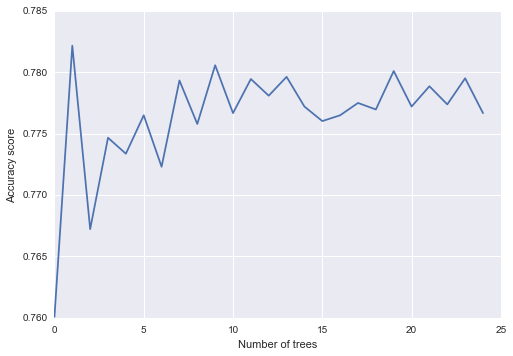

In [63]:
trees=range(25)
accuracy=np.zeros(25)

for idx in range(len(trees)):
   classifier=RandomForestClassifier(n_estimators=idx + 1)
   classifier=classifier.fit(pred_train,tar_train)
   predictions=classifier.predict(pred_test)
   accuracy[idx]=sklearn.metrics.accuracy_score(tar_test, predictions)
   
plt.plot(trees, accuracy)
plt.xlabel("Number of trees")
plt.ylabel("Accuracy score");

## Summary

This week shows that the 4 most important variables to tell if someone has ever used cannabis are, in that order :
1. Age
2. Grade completed
3. Ever smoked 100+ cigarettes
4. Family income

From the evolution of the accuracy score with the number of trees, it looks like a single decision tree is really good already (the accuracy score is even the higher in this case). But to start to see a stabilisation of the accuracy, 10 or  more trees should be used.